In [31]:
#LOAD DATA AS DATAFRAME
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import re
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor


%matplotlib inline


df = pd.read_csv('tour_logs_train.csv', na_values=['NA', 'NaN', '', 'null', '?'])
pd.read_csv('tour_logs_train.csv').dropna()
df.head()

,Gig_ID,Venue_ID,Show_DateTime,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Merch_Sales_Post_Show,Crowd_Energy
0,Gig_0000,V_Alpha,2024-03-07 21:00:00,3,5.0,52.93,464.0,2,Rainy,Waning Crescent,Leather,916,64.96
1,Gig_0001,V_Beta,2024-09-05 22:00:00,3,2.0,66.33,388.0,5,Clear,New Moon,Leather,1003,66.42
2,Gig_0002,V_Delta,2024-03-09 15:00:00,5,1.0,51.37,679.0,1,Rainy,Waning Crescent,Denim,720,42.58
3,Gig_0003,V_Beta,08/07/2024 08:00 AM,0,10.0,64.77,454.0,1,Rainy,New Moon,Leather,0,0.00
4,Gig_0004,V_Delta,2024-04-26 17:00:00,4,8.0,47.34,654.0,5,Cloudy,Full Moon,Spandex,950,67.55


PRE-PROCESSING & DATA CLEANING

In [32]:
# TICKET_PRICE_PREPROCESSING

df = pd.read_csv('tour_logs_train.csv')

df.drop(df.index[df['Ticket_Price'].isna()] , inplace = True)

def CurrConv(price,curr):
    price = price.lstrip(curr)      
    price = float(price) 
    price = round(price,2)
    if(curr == '£' ):          
        price *= 1.27    
    if(curr == '€' ):       
        price *= 1.09  
    
    return  round(price,2)    

#Convert Free to 0
mask4 = (df['Ticket_Price'] == 'Free')
df.loc[mask4, 'Ticket_Price'] = 0           

#Curr Conversion
mask1 = df['Ticket_Price'].str.startswith('€', na = False)
mask2 = df['Ticket_Price'].str.startswith('£', na = False)
df.loc[mask1, 'Ticket_Price'] = df.loc[mask1, 'Ticket_Price'].apply(lambda x : CurrConv(x,'€'))
df.loc[mask2, 'Ticket_Price'] = df.loc[mask2, 'Ticket_Price'].apply(lambda x : CurrConv(x,'£'))

#Check for Negative Values, None Found
mask3 = df['Ticket_Price'].str.startswith('-', na = False)
df.loc[mask3, 'Ticket_Price']

#Check for $ in start
mask4 = df['Ticket_Price'].str.startswith('$', na = False)
df.loc[mask4, 'Ticket_Price'] = df.loc[mask4, 'Ticket_Price'].apply(lambda x : x.lstrip('$'))

#Check for D at last as in USD
mask4 = df['Ticket_Price'].str.endswith('D', na = False)
df.loc[mask4, 'Ticket_Price'] = df.loc[mask4, 'Ticket_Price'].apply(lambda x : x.rstrip(' USD'))


#Check for VIP Prices, ignoring it as of now
mask4 = df['Ticket_Price'].str.endswith(')', na = False)
df.loc[mask4, 'Ticket_Price'] = df.loc[mask4, 'Ticket_Price'].str.replace(r'\(VIP:.*\)','',regex=True).str.strip()

df['Ticket_Price'] = df['Ticket_Price'].astype(float)

#Checking for outliers in upper bound of price, All reasonable
mask5 = df['Ticket_Price'] > 100
df.loc[mask5, 'Ticket_Price']



74      100.15
286     106.00
437     113.77
553     108.11
638     101.87
1312    113.11
1334    120.00
1630    105.00
1911    101.02
Name: Ticket_Price, dtype: float64

In [33]:
#CROWD_ENERGY_PREPROCESSING

mask = (df['Crowd_Energy'] > 100) | (df['Crowd_Energy'] < 0)
df.loc[mask]
df.drop(df[mask | df['Crowd_Energy'].isna()].index, inplace=True)


In [34]:
#HANDLING_NEGATIVE_NaN_VOLUME_LEVELS
df['Volume_Level'] = df['Volume_Level']
mask = (df['Volume_Level'] <= 0) | (df['Volume_Level'].isna())
df.drop(index =df.index[mask], inplace=True)


In [35]:
#CROWD_SIZE_OUTLIER
df[(df['Crowd_Size'] > 1000)]

#This gives 11 outputs, two of which are outliers. Both outliers are 50,000. Removing Them
df.drop(index = df.index[(df['Crowd_Size'] > 2000) | (df['Crowd_Size'].isna()) | (df['Crowd_Size'] < 0)], inplace=True)

In [36]:
#HANDLING DATE TIME -> CREATED ANOTHER SERIES OF TIME LABELS (Morning, Afternoon etc). REMOVED ROWS WITH ONLY DATE


#Identifying the Terms of Time Name
mask = df['Show_DateTime'].str.contains('2024', na = False)
df.loc[~mask, 'Show_DateTime'].value_counts()

#Change the Text Labels to Time Values, Let the Date Values be Arbitrary as of now
TimeToLabel = {'20:00:00' : 'Late Night'  ,  '17:00:00' : 'Evening' ,  '06:00:00' : 'Morning',  '12:00:00' : 'Afternoon' }

mask = df['Show_DateTime'].str.contains('Late Night')
df.loc[mask, 'Show_DateTime'] = '20:00:00'

mask = df['Show_DateTime'].str.contains('Evening')
df.loc[mask, 'Show_DateTime'] =  '17:00:00'

mask = df['Show_DateTime'].str.contains('Morning')
df.loc[mask, 'Show_DateTime'] = '06:00:00'

mask = df['Show_DateTime'].str.contains('Afternoon')
df.loc[mask, 'Show_DateTime'] = '12:00:00' 


#Ensuring that No show has been performed at 12 AM. I will use this info to remove the 'only dates' entry later
mask = df['Show_DateTime'].str.contains('00:00:00')
print(df.loc[mask, 'Show_DateTime'].sum())


df['Show_DateTime'] = pd.to_datetime(df['Show_DateTime'], format = 'mixed', dayfirst=True, errors = 'ignore')
df['Show_DateTime'] = df['Show_DateTime'].dt.time
df.drop(df.index[df['Show_DateTime'] == '00:00:00'] , inplace = True)



#Now since only labels of time matter in context here, I rechanged them to relative labels according to timetolabel dict cutoffs

mask1 = (df['Show_DateTime'].astype(str) >= '06:00:00') & (df['Show_DateTime'].astype(str) < '12:00:00')
mask2 = (df['Show_DateTime'].astype(str) >= '12:00:00') & (df['Show_DateTime'].astype(str) < '17:00:00')
mask3 = (df['Show_DateTime'].astype(str) >= '17:00:00') & (df['Show_DateTime'].astype(str) < '20:00:00')
mask4 = (df['Show_DateTime'].astype(str) >= '20:00:00') 


df.loc[mask1, 'Time_Label'] = 'Morning'
df.loc[mask2, 'Time_Label'] = 'Afternoon'
df.loc[mask3, 'Time_Label'] = 'Evening'
df.loc[mask4, 'Time_Label'] = 'Late Night'


df.drop(index = df.index[(df['Time_Label'].isna())], inplace=True)      
df




0


C:\Users\ayush\AppData\Local\Temp\ipykernel_21224\3980028271.py:29: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df['Show_DateTime'] = pd.to_datetime(df['Show_DateTime'], format = 'mixed', dayfirst=True, errors = 'ignore')


,Gig_ID,Venue_ID,Show_DateTime,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Merch_Sales_Post_Show,Crowd_Energy,Time_Label
0,Gig_0000,V_Alpha,21:00:00,3,5.0,52.93,464.0,2,Rainy,Waning Crescent,Leather,916,64.96,Late Night
1,Gig_0001,V_Beta,22:00:00,3,2.0,66.33,388.0,5,Clear,New Moon,Leather,1003,66.42,Late Night
2,Gig_0002,V_Delta,15:00:00,5,1.0,51.37,679.0,1,Rainy,Waning Crescent,Denim,720,42.58,Afternoon
3,Gig_0003,V_Beta,08:00:00,0,10.0,64.77,454.0,1,Rainy,New Moon,Leather,0,0.00,Morning
4,Gig_0004,V_Delta,17:00:00,4,8.0,47.34,654.0,5,Cloudy,Full Moon,Spandex,950,67.55,Evening
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,Gig_1993,V_Beta,23:00:00,0,7.0,55.01,323.0,3,Clear,New Moon,Denim,885,58.87,Late Night
1994,Gig_1994,V_Beta,20:00:00,6,4.0,62.86,432.0,4,Cloudy,Waxing Gibbous,Denim,942,61.32,Late Night
1996,Gig_1996,V_Beta,23:00:00,3,7.0,26.94,588.0,5,Stormy,Full Moon,Spandex,897,65.60,Late Night
1997,Gig_1997,V_Beta,20:00:00,4,2.0,57.54,649.0,1,Rainy,Waning Gibbous,Leather,670,60.34,Late Night


EXPLORATORY DATA ANALYTICS

In [37]:
#MOONPHASE vs CROWDENERGY
df[['Moon_Phase','Crowd_Energy']].sort_values(by ='Moon_Phase', ascending=False )
mask1 = (df['Crowd_Energy'] >= 75)
counts = df.loc[mask1,'Moon_Phase'].value_counts(normalize=True)*100
print(round(counts,2))


Moon_Phase
Last Quarter       15.56
Waxing Crescent    14.40
Waxing Gibbous     13.62
New Moon           12.84
First Quarter      12.45
Waning Gibbous     11.28
Waning Crescent    10.12
Full Moon           9.73
Name: proportion, dtype: float64


In [38]:
#OUTFIT vs CROWDENERGY
df[['Band_Outfit','Crowd_Energy']].sort_values(by ='Band_Outfit', ascending=False )
mask1 = (df['Crowd_Energy'] >= 75)
counts = df.loc[mask1,'Band_Outfit'].value_counts(normalize=True)*100
print(round(counts,2))



Band_Outfit
Leather    44.36
Denim      35.02
Spandex    20.62
Name: proportion, dtype: float64


In [39]:
#WEATHER vs CROWDENERGY
df[['Weather','Crowd_Energy']].sort_values(by ='Weather', ascending=False )
mask1 = (df['Crowd_Energy'] >= 75)
counts = df.loc[mask1,'Weather'].value_counts(normalize=True)*100
print(round(counts,2))


Weather
Rainy     27.24
Clear     25.29
Cloudy    24.51
Stormy    22.96
Name: proportion, dtype: float64


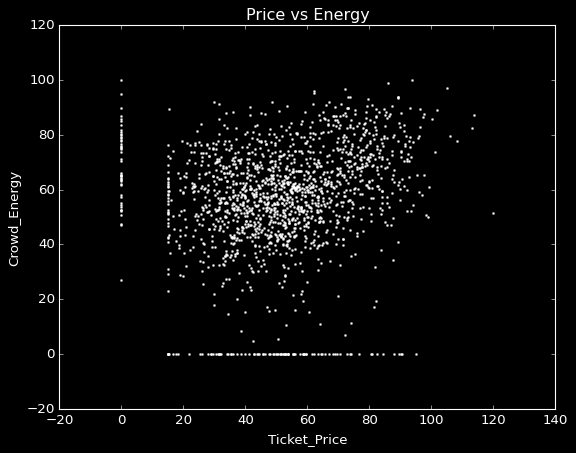

In [40]:
#TICKETPRICE vs CROWDENERGY
plt.style.use('dark_background')
x = df['Ticket_Price']
y = df['Crowd_Energy']
plt.scatter(x,y, c= 'w', marker='x', s = 2.5)
plt.xlabel('Ticket_Price')
plt.ylabel('Crowd_Energy')
plt.title('Price vs Energy')
plt.show()

In [41]:
#DAY vs CROWDENERGY
mask1 = (df['Crowd_Energy'] >=70) 
counts = df.loc[mask1,'Day_of_Week'].value_counts(normalize=True)*100
print(counts.sort_values)


<bound method Series.sort_values of Day_of_Week
6    19.240506
5    17.974684
1    15.443038
0    14.430380
3    12.911392
4    10.126582
2     9.873418
Name: proportion, dtype: float64>


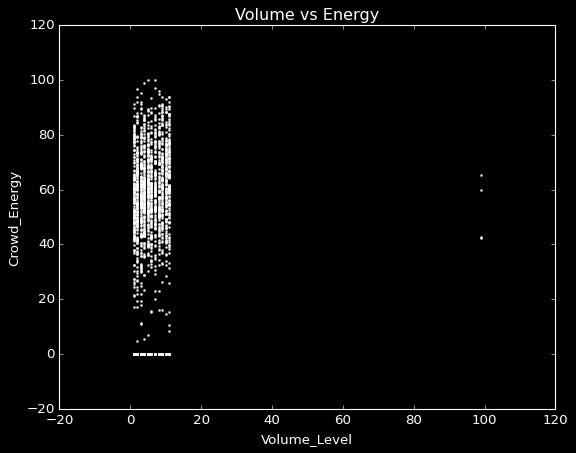

In [42]:
#VOLUME vs CROWDENERGY
plt.style.use('dark_background')
x = df['Volume_Level']
y = df['Crowd_Energy']
plt.scatter(x,y, c= 'w', marker='x', s = 2.5)
plt.xlabel('Volume_Level')
plt.ylabel('Crowd_Energy')
plt.title('Volume vs Energy')
plt.show()

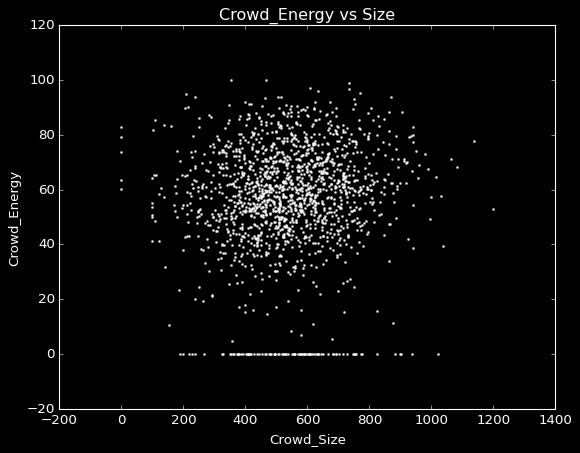

In [43]:
#CROWDSIZE vs CROWDENERGY
plt.style.use('dark_background')
x = df['Crowd_Size']
y = df['Crowd_Energy']
plt.scatter(x,y, c= 'w', marker='x', s = 2.5)
plt.xlabel('Crowd_Size')
plt.ylabel('Crowd_Energy')
plt.title('Crowd_Energy vs Size')
plt.show()

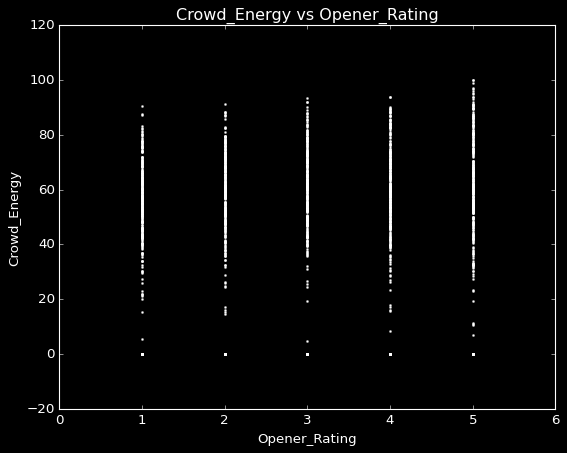

In [44]:
#OPENERRATING vs CROWDENERGY
plt.style.use('dark_background')
x = df['Opener_Rating']
y = df['Crowd_Energy']
plt.scatter(x,y, c= 'w', marker='x', s = 2.5)
plt.xlabel('Opener_Rating')
plt.ylabel('Crowd_Energy')
plt.title('Crowd_Energy vs Opener_Rating')
plt.show()

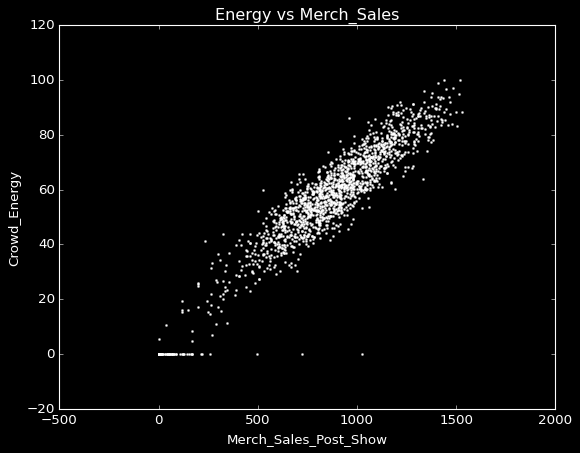

In [45]:
#MERCHSALES_CROWDENERGY
plt.style.use('dark_background')
x = df['Merch_Sales_Post_Show']
y = df['Crowd_Energy']
plt.scatter(x,y, c= 'w', marker='x', s = 2.5)
plt.xlabel('Merch_Sales_Post_Show')
plt.ylabel('Crowd_Energy')
plt.title('Energy vs Merch_Sales')
plt.show()

C:\Users\ayush\AppData\Local\Temp\ipykernel_21224\429926718.py:16: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  axs[0].scatter(VGp.get_group('V_Alpha')['Opener_Rating'], VGp.get_group('V_Alpha')['Crowd_Energy'], c= 'k', marker='x', s = 15)
C:\Users\ayush\AppData\Local\Temp\ipykernel_21224\429926718.py:16: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  axs[0].scatter(VGp.get_group('V_Alpha')['Opener_Rating'], VGp.get_group('V_Alpha')['Crowd_Energy'], c= 'k', marker='x', s = 15)
C:\Users\ayush\AppData\Local\Temp\ipykernel_21224\429926718.py:17: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `

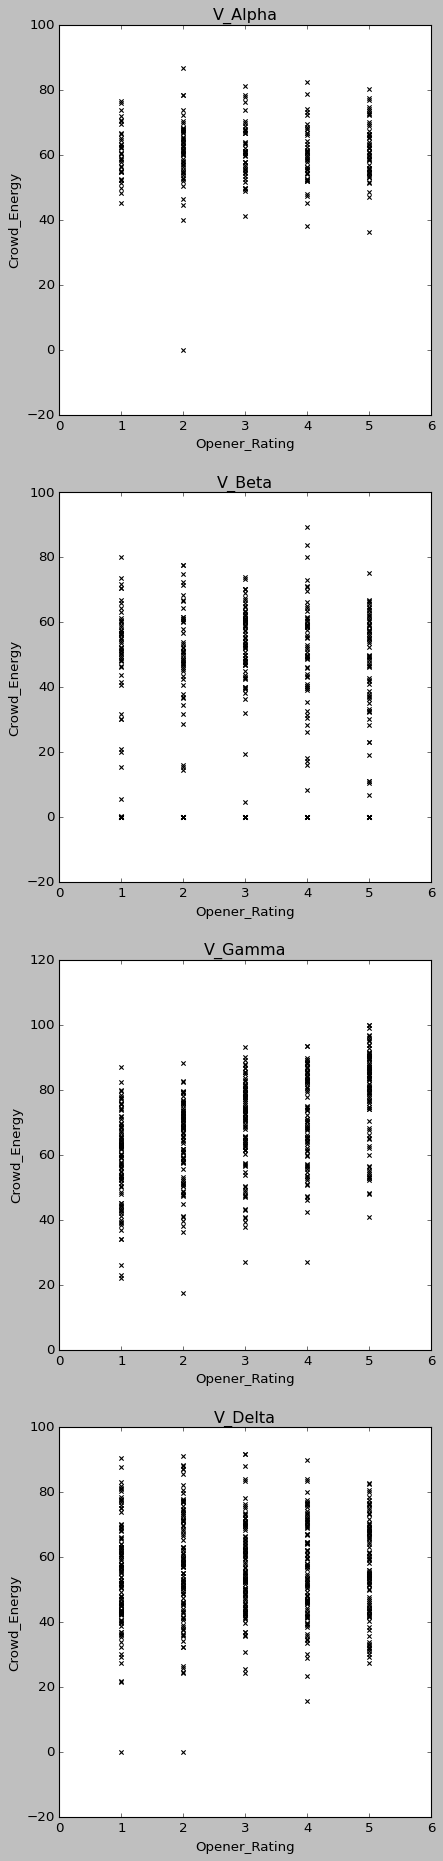

In [46]:
#OPENER_RATING vs ENERGY wrt PLACE

plt.style.use('classic')
VGp = df.groupby(['Venue_ID'])

figs,axs = plt.subplots(nrows = 4, ncols =1, figsize = (6,28))
for i in range(4):
    axs[i].set_xlabel('Opener_Rating')
    axs[i].set_ylabel('Crowd_Energy')

axs[0].set_title('V_Alpha')
axs[1].set_title('V_Beta')
axs[2].set_title('V_Gamma')
axs[3].set_title('V_Delta')

axs[0].scatter(VGp.get_group('V_Alpha')['Opener_Rating'], VGp.get_group('V_Alpha')['Crowd_Energy'], c= 'k', marker='x', s = 15)
axs[1].scatter(VGp.get_group('V_Beta')['Opener_Rating'], VGp.get_group('V_Beta')['Crowd_Energy'], c= 'k', marker='x', s = 15)
axs[2].scatter(VGp.get_group('V_Gamma')['Opener_Rating'], VGp.get_group('V_Gamma')['Crowd_Energy'], c= 'k', marker='x', s = 15)
axs[3].scatter(VGp.get_group('V_Delta')['Opener_Rating'], VGp.get_group('V_Delta')['Crowd_Energy'], c= 'k', marker='x', s =15)
plt.show()

#Since even when large number of 5 ratings were given, crowd energy wasnt neccesarily higher, it doesnt matter much

C:\Users\ayush\AppData\Local\Temp\ipykernel_21224\160740509.py:16: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  axs[0].scatter(VGp.get_group('V_Alpha')['Volume_Level'], VGp.get_group('V_Alpha')['Crowd_Energy'], c= 'k', marker='x', s = 15)
C:\Users\ayush\AppData\Local\Temp\ipykernel_21224\160740509.py:16: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  axs[0].scatter(VGp.get_group('V_Alpha')['Volume_Level'], VGp.get_group('V_Alpha')['Crowd_Energy'], c= 'k', marker='x', s = 15)
C:\Users\ayush\AppData\Local\Temp\ipykernel_21224\160740509.py:17: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(n

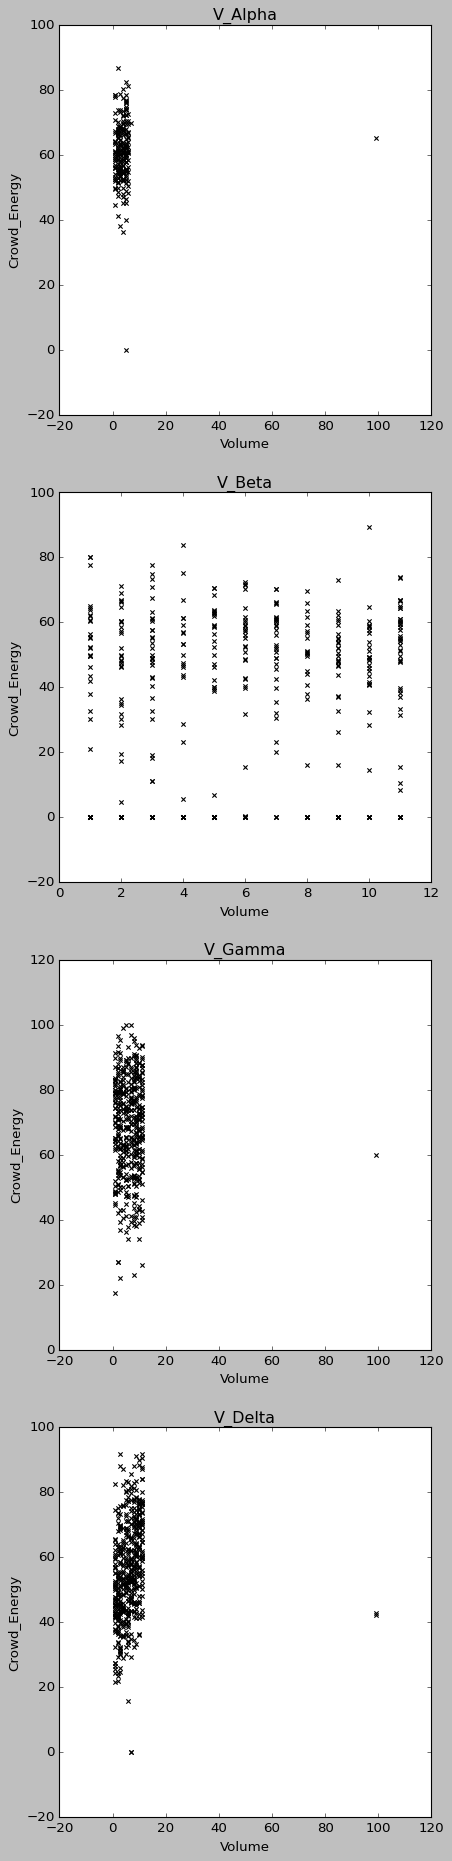

In [47]:
#VOLUME vs ENERGY wrt PLACE

plt.style.use('classic')
VGp = df.groupby(['Venue_ID'])

figs,axs = plt.subplots(nrows = 4, ncols =1, figsize = (6,28))
for i in range(4):
    axs[i].set_xlabel('Volume')
    axs[i].set_ylabel('Crowd_Energy')

axs[0].set_title('V_Alpha')
axs[1].set_title('V_Beta')
axs[2].set_title('V_Gamma')
axs[3].set_title('V_Delta')

axs[0].scatter(VGp.get_group('V_Alpha')['Volume_Level'], VGp.get_group('V_Alpha')['Crowd_Energy'], c= 'k', marker='x', s = 15)
axs[1].scatter(VGp.get_group('V_Beta')['Volume_Level'], VGp.get_group('V_Beta')['Crowd_Energy'], c= 'k', marker='x', s = 15)
axs[2].scatter(VGp.get_group('V_Gamma')['Volume_Level'], VGp.get_group('V_Gamma')['Crowd_Energy'], c= 'k', marker='x', s = 15)
axs[3].scatter(VGp.get_group('V_Delta')['Volume_Level'], VGp.get_group('V_Delta')['Crowd_Energy'], c= 'k', marker='x', s =15)
plt.show()

C:\Users\ayush\AppData\Local\Temp\ipykernel_21224\641302174.py:4: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  VGp.get_group('V_Alpha')['Opener_Rating']
C:\Users\ayush\AppData\Local\Temp\ipykernel_21224\641302174.py:16: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  axs[0].scatter(VGp.get_group('V_Alpha')['Ticket_Price'], np.log(VGp.get_group('V_Alpha')['Crowd_Size']), c= 'k', marker='x', s = 50)
C:\Users\ayush\AppData\Local\Temp\ipykernel_21224\641302174.py:17: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  axs[1].scatter(VGp.get_group

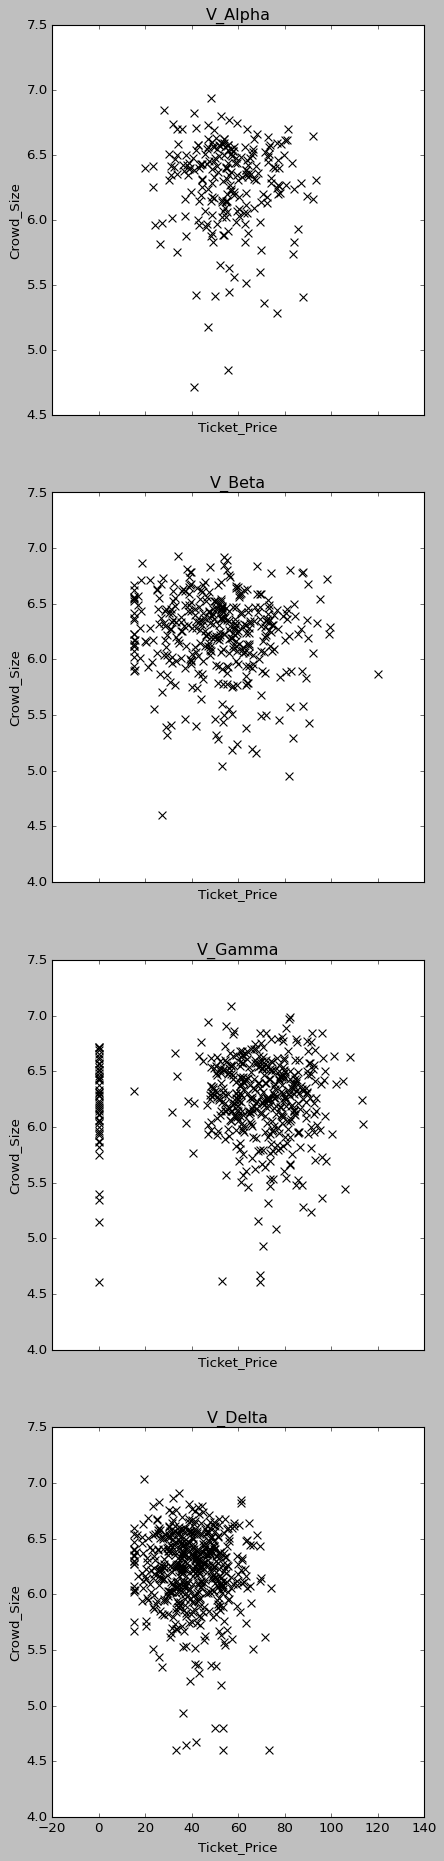

In [48]:

#TICKET_PRICE vs CROWD_SIZE wrt PLACE
plt.style.use('classic')
VGp = df.groupby(['Venue_ID'])
VGp.get_group('V_Alpha')['Opener_Rating']

figs,axs = plt.subplots(nrows = 4, ncols =1, figsize = (6,28), sharex=True)
for i in range(4):
    axs[i].set_xlabel('Ticket_Price')
    axs[i].set_ylabel('Crowd_Size')

axs[0].set_title('V_Alpha')
axs[1].set_title('V_Beta')
axs[2].set_title('V_Gamma')
axs[3].set_title('V_Delta')

axs[0].scatter(VGp.get_group('V_Alpha')['Ticket_Price'], np.log(VGp.get_group('V_Alpha')['Crowd_Size']), c= 'k', marker='x', s = 50)
axs[1].scatter(VGp.get_group('V_Beta')['Ticket_Price'], np.log(VGp.get_group('V_Beta')['Crowd_Size']), c= 'k', marker='x', s = 50)
axs[2].scatter(VGp.get_group('V_Gamma')['Ticket_Price'], np.log(VGp.get_group('V_Gamma')['Crowd_Size']), c= 'k', marker='x', s = 50)
axs[3].scatter(VGp.get_group('V_Delta')['Ticket_Price'], np.log(VGp.get_group('V_Delta')['Crowd_Size']), c= 'k', marker='x', s =50)
plt.show()

#Volume also is not that big a factor for Energy

C:\Users\ayush\AppData\Local\Temp\ipykernel_21224\1223900252.py:15: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  axs[0].scatter(np.log(VGp.get_group('V_Alpha')['Crowd_Size']), (VGp.get_group('V_Alpha')['Crowd_Energy']), c= 'k', marker='x', s = 50)
C:\Users\ayush\AppData\Local\Temp\ipykernel_21224\1223900252.py:15: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  axs[0].scatter(np.log(VGp.get_group('V_Alpha')['Crowd_Size']), (VGp.get_group('V_Alpha')['Crowd_Energy']), c= 'k', marker='x', s = 50)
C:\Users\ayush\AppData\Local\Temp\ipykernel_21224\1223900252.py:16: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version 

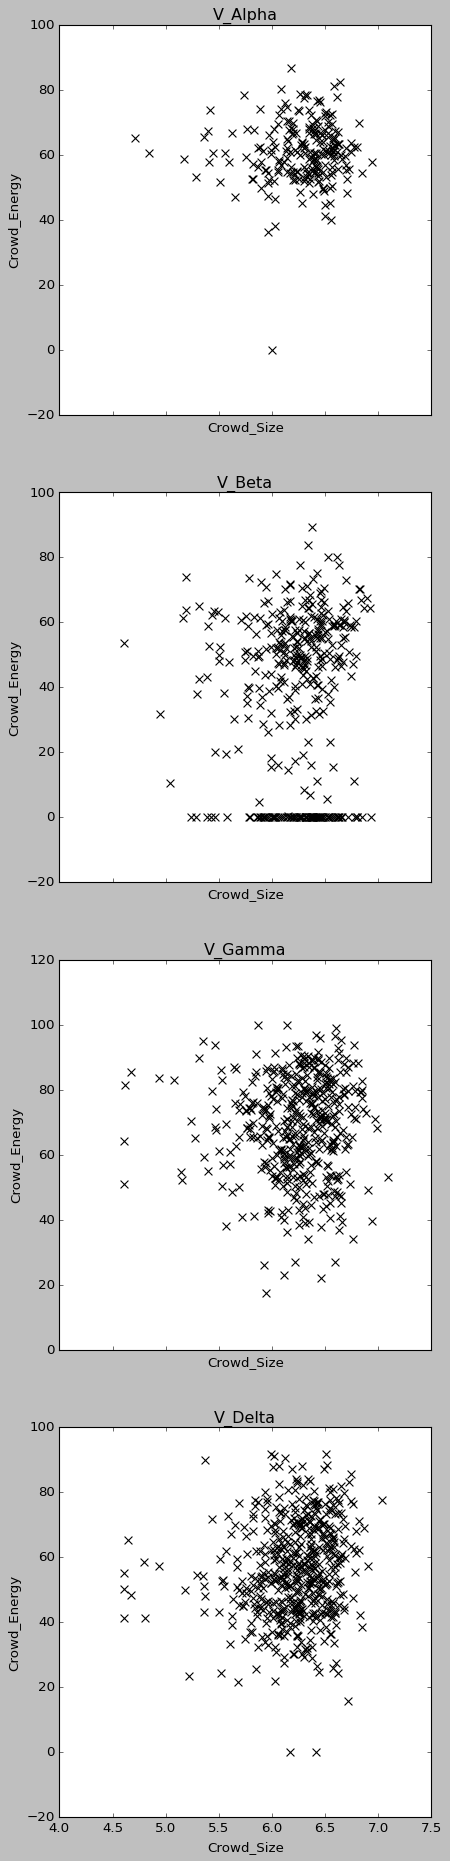

In [49]:

#CROWD_ENERGY vs CROWD_SIZE wrt PLACE
plt.style.use('classic')
VGp = df.groupby(['Venue_ID'])

figs,axs = plt.subplots(nrows = 4, ncols =1, figsize = (6,28), sharex=True)
for i in range(4):
    axs[i].set_xlabel('Crowd_Size')
    axs[i].set_ylabel('Crowd_Energy')

axs[0].set_title('V_Alpha')
axs[1].set_title('V_Beta')
axs[2].set_title('V_Gamma')
axs[3].set_title('V_Delta')

axs[0].scatter(np.log(VGp.get_group('V_Alpha')['Crowd_Size']), (VGp.get_group('V_Alpha')['Crowd_Energy']), c= 'k', marker='x', s = 50)
axs[1].scatter(np.log(VGp.get_group('V_Beta')['Crowd_Size']), (VGp.get_group('V_Beta')['Crowd_Energy']), c= 'k', marker='x', s = 50)
axs[2].scatter(np.log(VGp.get_group('V_Gamma')['Crowd_Size']), (VGp.get_group('V_Gamma')['Crowd_Energy']), c= 'k', marker='x', s = 50)
axs[3].scatter(np.log(VGp.get_group('V_Delta')['Crowd_Size']), (VGp.get_group('V_Delta')['Crowd_Energy']), c= 'k', marker='x', s =50)
plt.show()

#MoreOrLess Not much relation crowd size , crowd energy 

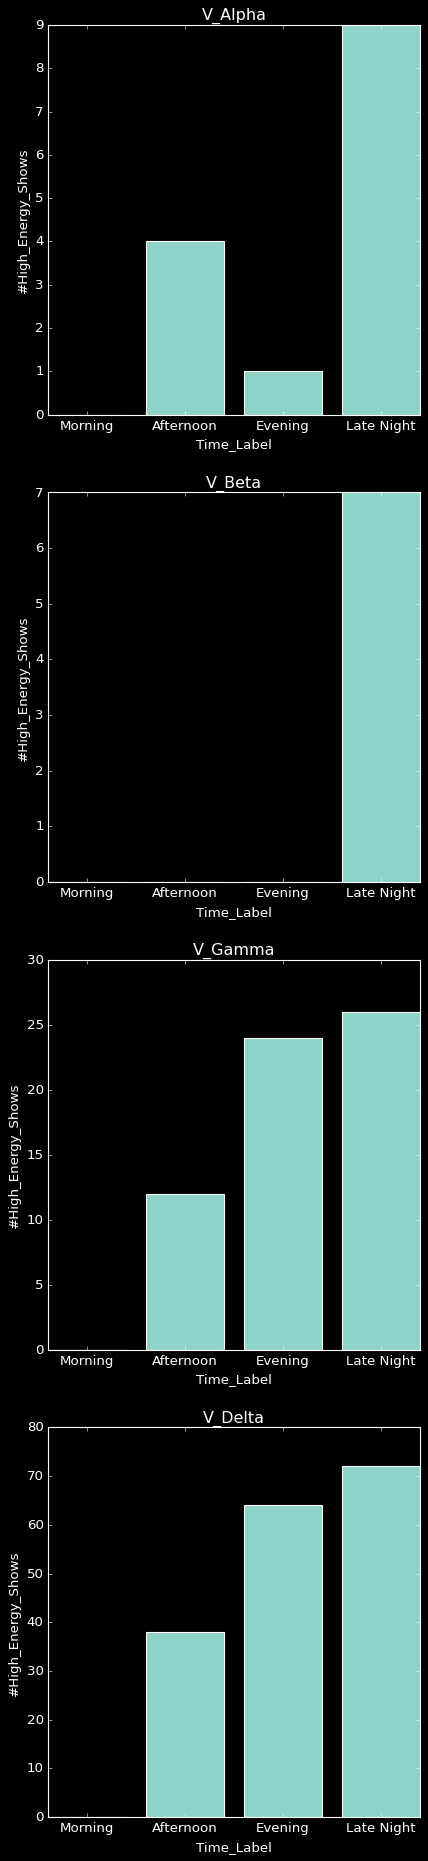

In [50]:
#CROWD_ENERGY vs SHOW_TIME wrt PLACE

plt.style.use('dark_background')
VGp = df.groupby(['Venue_ID'])

figs,axs = plt.subplots(nrows = 4, ncols =1, figsize = (6,28))

for i,(key,g) in enumerate(VGp):
    mask = (g['Time_Label'] == 'Morning') & (g['Crowd_Energy'] >= 75)
    a = mask.sum()

    mask = (g['Time_Label'] == 'Afternoon') & (g['Crowd_Energy'] >= 75)
    b = mask.sum()

    mask = (g['Time_Label'] == 'Evening') & (g['Crowd_Energy'] >= 75)
    c = mask.sum()

    mask = (g['Time_Label'] == 'Late Night') & (g['Crowd_Energy'] >= 75)
    d = mask.sum()

    axs[i].bar(['Morning', 'Afternoon','Evening', 'Late Night'], [a,b,c,d])


for i in range(4):
    axs[i].set_xlabel('Time_Label')
    axs[i].set_ylabel('#High_Energy_Shows')

axs[0].set_title('V_Alpha')
axs[1].set_title('V_Beta')
axs[2].set_title('V_Gamma')
axs[3].set_title('V_Delta')

plt.show()

#Ya!So the Goths do love the Night!


In [51]:
#Checking for a Killer Afternoon Show

mask = (df['Time_Label'] == 'Afternoon')
df.loc[mask, 'Crowd_Energy'].max()

np.float64(96.08)

MODEL TRAINING

In [52]:
#Relevant columns : Time_Label, Day_of_Week, Volume, BandOutfit, MoonPhase, Ticket_Price, Weather, Crowd_Size
#To Drop : Show_DateTime, Merch_Sales_Post_Show, Opener Rating


#Trying Feature Engineering to improve Accuracy
#Introduce Total_Revenue = 'Ticket_Price'*'Crowd_Size'

df['Total_Revenue'] = (df['Ticket_Price']*df['Crowd_Size'])

PreTrain_df = df
df = df.drop(columns = ['Show_DateTime', 'Merch_Sales_Post_Show','Opener_Rating', 'Gig_ID'])

In [53]:
#Split df into target and input
y = df['Crowd_Energy']

X = df.drop(columns=['Crowd_Energy'])

df.head(1)

,Venue_ID,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Weather,Moon_Phase,Band_Outfit,Crowd_Energy,Time_Label,Total_Revenue
0,V_Alpha,3,5.0,52.93,464.0,Rainy,Waning Crescent,Leather,64.96,Late Night,24559.52


In [54]:
#One Hot Encoding

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state= 42)
 

category = ['Venue_ID', 'Day_of_Week', 'Weather', 'Moon_Phase', 'Band_Outfit', 'Time_Label']
numbers= ['Volume_Level', 'Total_Revenue','Ticket_Price','Crowd_Size']

Mypreprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), category),
            ('num', 'passthrough', numbers)
        ]
)

X_train = Mypreprocessor.fit_transform(X_train)
X_test = Mypreprocessor.transform(X_test)


In [55]:
#Default Parameter Score w/o Hypertuning

model = XGBRegressor()
model.fit(X_train,y_train)
a = model.score(X_test,y_test)
a

0.6066226646717074

In [56]:
#Applying Hyperparameter Tuning with XGBoostRegressor using GridSearchCV


predict = GridSearchCV(XGBRegressor(),{'n_estimators' : [1000,1500,500], 'learning_rate' : [0.03,0.06,0.09] ,'max_depth' : [2,4,8], 'reg_lambda' : [1,2.5,5]}, cv =5, return_train_score=False )
predict.fit(X_train,y_train)



ResultDf = pd.DataFrame(predict.cv_results_)


In [57]:

print(predict.best_params_)



{'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 500, 'reg_lambda': 5}


In [58]:
best_model = predict.best_estimator_
test_score = best_model.score(X_test,y_test)
test_score

0.6633788622433305

CREATING PREDICTION.CSV


CLEANING TEST DATASET WITH THE SAME CODE AS TRAIN

In [ ]:
df = pd.read_csv('tour_logs_test_input.csv', na_values=['NA', 'NaN', '', 'null', '?'])
pd.read_csv('tour_logs_test_input.csv').dropna()
df.head()

# TICKET_PRICE_PREPROCESSING

df = pd.read_csv('tour_logs_test_input.csv')

df.drop(df.index[df['Ticket_Price'].isna()] , inplace = True)

def CurrConv(price,curr):
    price = price.lstrip(curr)      
    price = float(price) 
    price = round(price,2)
    if(curr == '£' ):          
        price *= 1.27    
    if(curr == '€' ):       
        price *= 1.09  
    
    return  round(price,2)    

#Convert Free to 0
mask4 = (df['Ticket_Price'] == 'Free')
df.loc[mask4, 'Ticket_Price'] = 0           

#Curr Conversion
mask1 = df['Ticket_Price'].str.startswith('€', na = False)
mask2 = df['Ticket_Price'].str.startswith('£', na = False)
df.loc[mask1, 'Ticket_Price'] = df.loc[mask1, 'Ticket_Price'].apply(lambda x : CurrConv(x,'€'))
df.loc[mask2, 'Ticket_Price'] = df.loc[mask2, 'Ticket_Price'].apply(lambda x : CurrConv(x,'£'))

#Check for Negative Values, None Found
mask3 = df['Ticket_Price'].str.startswith('-', na = False)
df.loc[mask3, 'Ticket_Price']

#Check for $ in start
mask4 = df['Ticket_Price'].str.startswith('$', na = False)
df.loc[mask4, 'Ticket_Price'] = df.loc[mask4, 'Ticket_Price'].apply(lambda x : x.lstrip('$'))

#Check for D at last as in USD
mask4 = df['Ticket_Price'].str.endswith('D', na = False)
df.loc[mask4, 'Ticket_Price'] = df.loc[mask4, 'Ticket_Price'].apply(lambda x : x.rstrip(' USD'))


#Check for VIP Prices, ignoring it as of now
mask4 = df['Ticket_Price'].str.endswith(')', na = False)
df.loc[mask4, 'Ticket_Price'] = df.loc[mask4, 'Ticket_Price'].str.replace(r'\(VIP:.*\)','',regex=True).str.strip()

df['Ticket_Price'] = df['Ticket_Price'].astype(float)

#Checking for outliers in upper bound of price, All reasonable
mask5 = df['Ticket_Price'] > 100
df.loc[mask5, 'Ticket_Price']



#HANDLING DATE TIME -> CREATED ANOTHER SERIES OF TIME LABELS (Morning, Afternoon etc). REMOVED ROWS WITH ONLY DATE


#Identifying the Terms of Time Name
mask = df['Show_DateTime'].str.contains('2024', na = False)
df.loc[~mask, 'Show_DateTime'].value_counts()

#Change the Text Labels to Time Values, Let the Date Values be Arbitrary as of now
TimeToLabel = {'20:00:00' : 'Late Night'  ,  '17:00:00' : 'Evening' ,  '06:00:00' : 'Morning',  '12:00:00' : 'Afternoon' }

mask = df['Show_DateTime'].str.contains('Late Night')
df.loc[mask, 'Show_DateTime'] = '20:00:00'

mask = df['Show_DateTime'].str.contains('Evening')
df.loc[mask, 'Show_DateTime'] =  '17:00:00'

mask = df['Show_DateTime'].str.contains('Morning')
df.loc[mask, 'Show_DateTime'] = '06:00:00'

mask = df['Show_DateTime'].str.contains('Afternoon')
df.loc[mask, 'Show_DateTime'] = '12:00:00' 


#Ensuring that No show has been performed at 12 AM. I will use this info to remove the 'only dates' entry later
mask = df['Show_DateTime'].str.contains('00:00:00')


df['Show_DateTime'] = pd.to_datetime(df['Show_DateTime'], format = 'mixed', dayfirst=True, errors = 'ignore')
df['Show_DateTime'] = df['Show_DateTime'].dt.time
# df.drop(df.index[df['Show_DateTime'] == '00:00:00'] , inplace = True)



#Now since only labels of time matter in context here, I rechanged them to relative labels according to timetolabel dict cutoffs

mask1 = (df['Show_DateTime'].astype(str) >= '06:00:00') & (df['Show_DateTime'].astype(str) < '12:00:00')
mask2 = (df['Show_DateTime'].astype(str) >= '12:00:00') & (df['Show_DateTime'].astype(str) < '17:00:00')
mask3 = (df['Show_DateTime'].astype(str) >= '17:00:00') & (df['Show_DateTime'].astype(str) < '20:00:00')
mask4 = (df['Show_DateTime'].astype(str) >= '20:00:00') | (df['Show_DateTime'].astype(str) < '06:00:00')


df.loc[mask1, 'Time_Label'] = 'Morning'
df.loc[mask2, 'Time_Label'] = 'Afternoon'
df.loc[mask3, 'Time_Label'] = 'Evening'
df.loc[mask4, 'Time_Label'] = 'Late Night'

df['Total_Revenue'] = (df['Ticket_Price']*df['Crowd_Size'])

PreTrain_df = df
df = df.drop(columns = ['Show_DateTime', 'Merch_Sales_Post_Show','Opener_Rating', 'Gig_ID'])

df.to_csv(r'C:\Users\ayush\OneDrive\Desktop\Personal\CC ML\output.csv', index=False)




0


C:\Users\ayush\AppData\Local\Temp\ipykernel_21224\4163896710.py:85: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df['Show_DateTime'] = pd.to_datetime(df['Show_DateTime'], format = 'mixed', dayfirst=True, errors = 'ignore')


In [60]:
import joblib

joblib.dump(Mypreprocessor, r'C:\Users\ayush\OneDrive\Desktop\Personal\CC ML\preprocessor.pkl')
joblib.dump(predict.best_estimator_, r'C:\Users\ayush\OneDrive\Desktop\Personal\CC ML\xgb_model.pkl')

['C:\\Users\\ayush\\OneDrive\\Desktop\\Personal\\CC ML\\xgb_model.pkl']

In [ ]:
Mypreprocessor = joblib.load("preprocessor.pkl")  
xgb_model = joblib.load("xgb_model.pkl")          

        
PRED_COL = 'Crowd_Energy'
ID_COL = 'Gig_ID'


category = ['Venue_ID','Day_of_Week','Weather','Moon_Phase','Band_Outfit','Time_Label']
numbers  = ['Volume_Level','Total_Revenue','Ticket_Price','Crowd_Size']
expected = numbers + category


X_new = pd.read_csv("output.csv")[expected]

preds = xgb_model.predict(Mypreprocessor.transform(X_new))

pd.DataFrame({
    ID_COL: pd.read_csv('tour_logs_test_input.csv')['Gig_ID'],
    PRED_COL: preds
}).to_csv(r"C:\Users\ayush\OneDrive\Desktop\Personal\CC ML\predictions.csv", index=False)
